# Assignment 2

All members of the group contributed equally in completing the assignment.

[Github](https://github.com/RSM-git/assignment2_compsocsci)

# Formalia:

Please read the [assignment overview page](https://laura.alessandretti.com/comsocsci2023/assignments.html) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Mar 28th at 23:59. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Assignment, Assignment 2)_. 

Remember to include in the first cell of your notebook:
* the link to your group's Git repository (if you don't have a shared Git repository, it's fine. Remember to do it next time)
* group members' contributions

# Imports

In [20]:
import pandas as pd
import networkx as nx
from networkx.readwrite import json_graph
import numpy as np
import polars as pl
import ast
import os
import pickle
import requests
from time import sleep
import copy
import json
import random
import matplotlib.pyplot as plt
import community
from netwulf import visualize
from scipy.stats import norm
import nltk
import re
nltk.download("stopwords")
random.seed(2)
np.random.seed(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
def get_largest_component(filename: str):
    with open(filename) as f:
        author_network = json.load(f)
    
    author_network = nx.node_link_graph(author_network)
    Gcc = sorted(nx.connected_components(author_network), reverse=True, key=len)[0]
    G0 = author_network.subgraph(Gcc)
    return G0

# Part 1: Mixing Patterns and Assortativity

Let's dig in and try to understand more about the network of Computational Social Scientists using more advanced features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below. For the exercises below, you shall use the network you built in [Week 4](https://github.com/lalessan/comsocsci2023/blob/main/lectures/Week4.ipynb).


> **Exercise 1: Mixing Patterns and Assortativity.** 
>
> * For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.
>
> * Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.
>
> * Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?
>
> * Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (__Hint__: See [this paper](https://nbviewer.org/github/suneman/socialgraphs2019/blob/master/lectures/Week5.ipynb), eq (2)). **Important**: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.
>
> * Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.
>
>


## Creating the network

In [27]:
# load of author and paper csvs
author_df = pd.read_csv("all_authors.csv", index_col="id")

# we use polars as pandas is way too slow to use for filtering this
# large amount of data
paper_df = pl.scan_csv("all_papers.csv")

We start by finding the css papers

In [ ]:
social_science_fields = {"Political Science", "Sociology", "Economics"}
quantitative_fields = {"Mathematics", "Physics", "Computer Science"}

In [ ]:
# start with filtering the criterias that are supported by polars as these are much faster than the apply function
paper_df = paper_df.filter((~pl.col("fields").str.contains("Biology")) & (pl.col("year") > 2008) & (~pl.col("doi").str.contains("None"))).collect()

In [ ]:
# custom function for apply
def has_sosci_field(fields: str):
    fields = ast.literal_eval(fields)
    # check if paper has social science field
    if len(set(fields).intersection(social_science_fields)) > 0:
        return True


paper_df = paper_df.filter(pl.col("fields").apply(has_sosci_field))

In [ ]:
# custom function for apply
def is_quantitative(row: dict):
    fields = set(ast.literal_eval(row["fields"]))
    # check if paper has quantitative field
    if len(fields.intersection(quantitative_fields)) > 0:
        return True

    authors = ast.literal_eval(row["authors"])
    authors = [a for a in authors if a is not None]
    # make sure that there are at least one author that is not None
    if len(authors) == 0:
        return False

    # check if paper has an author in quantitative field
    for author in authors:
        author = int(author)
        if author in author_df.index:
            if author_df.loc[int(author), "field"] in quantitative_fields:
                return True

    return False
    
paper_df = paper_df.filter(pl.struct(["authors", "fields"]).apply(is_quantitative))

In [ ]:
print(f"Number of CSS papers: {len(paper_df)}")

Number of CSS papers: 8297


In [ ]:
# save the dataframe
paper_df.write_csv("css_papers.csv")

In [ ]:
# with the filtering being done, we swap back to pandas
css_paper_df = pd.read_csv("css_papers.csv", index_col="id")

# remove the redundant index column added by polars
css_paper_df = css_paper_df.drop(columns="Unnamed: 0")

In [ ]:
# some papers have None as an author which we remove
for i, row in css_paper_df.iterrows():
    authors = ast.literal_eval(row["authors"])
    authors = [a for a in authors if a is not None]
    row["authors"] = authors
    css_paper_df.loc[row.name] = row

In [ ]:
# save the final version of css paper df
css_paper_df.to_csv("css_papers.csv")

In [28]:
css_paper_df = pd.read_csv("css_papers.csv", index_col="id")

In [29]:
# since we don't have all the authors of the paper df in the author df, we
# need to check if any of the css authors are missing from the author df

# get all unique authors
css_authors = set()
for i, row in css_paper_df.iterrows():
    authors = ast.literal_eval(row["authors"])
    authors = list(map(int, authors))
    css_authors = css_authors.union(set(authors))

In [30]:
# find the missing ones
missing_authors = []
for author in css_authors:
    if author not in author_df.index:
        missing_authors.append(author)

In [31]:
# set of authors that we have information on
known_authors = css_authors - set(missing_authors)

In [32]:
print(f"We have information on {len(known_authors)}")
print(f"{len(missing_authors)} authors are missing")

We have information on 3539
23026 authors are missing


Since we are missing so many authors, we chose to request the api yet again

In [22]:
# request missing authors
def make_author_requests(ids: list[str], start_index: int = 0, end_index: int = None, batch_size=30, save_threshold=500, suffix: str = None):
    if save_threshold < batch_size:
        print("save_threshold must be higher than batch_size")
        exit()
    batch_url = "https://api.semanticscholar.org/graph/v1/author/batch"
    responses = []
    requests_made = 0
    counter = start_index
    errors = []
    save_increment = int(np.ceil(save_threshold/batch_size) * batch_size)
    save_target = save_increment
    save_start_idx = 0
    if suffix is None:
        suffix = ""
    if end_index is None:
        end_index = len(ids)
    else:
        end_index = min(len(ids), end_index)
    while counter < end_index:
        current_ids = ids[counter: counter + batch_size]
        data = {"ids": current_ids}
        params = {"fields": "name,aliases,papers.s2FieldsOfStudy"}
        try:
            response = requests.post(batch_url, json=data, params=params).json()
            
            if isinstance(response, dict):
                errors.append(response)
                if response["message"] == "Too Many Requests":
                    sleep(300)
                else:
                    counter += batch_size
            else:
                responses.append(response)
                counter += batch_size
                requests_made += batch_size
                if requests_made == save_target:
                    with open(f"responses_{save_start_idx+start_index}_{save_target+start_index}" + suffix + ".pkl", "wb") as f:
                        pickle.dump(responses, f)
                    responses = []
                    save_start_idx = save_target
                    save_target += save_increment
        except Exception as e:
            print(e)
            counter += batch_size
            requests_made += batch_size
            if requests_made == save_target:
                with open(f"responses_{save_start_idx+start_index}_{save_target+start_index}" + suffix + ".pkl", "wb") as f:
                    pickle.dump(responses, f)
                responses = []
                save_start_idx = save_target
                save_target += save_increment

    with open(f"responses_{save_start_idx+start_index}_{end_index}.pkl", "wb") as f:
        pickle.dump(responses, f)
    return errors

In [ ]:
# Kris
# make_author_requests(missing_authors, batch_size=30, start_index=0, end_index=7675)

# Rasmus
# make_author_requests(missing_authors, batch_size=30, start_index = 7675, end_index = 7675*2)

# Victor
make_author_requests(missing_authors, batch_size=30, start_index = 7675*2)

In [33]:
# process the responses from the api

# load all the pickle files
all_responses = []
all_files = os.listdir()
for file in all_files:
    if "responses" in file:
        with open(file, "rb") as f:
            all_responses.append(pickle.load(f))

In [34]:
def get_primary_field(papers: list) -> str:
    # find the primary field of an author based of the fields of their papers
    fields = {}
    for paper in papers:
        fields_of_study = paper["s2FieldsOfStudy"]
        for field in fields_of_study:
            category = field["category"]
            if category not in fields:
                fields[category] = 1
            else:
                fields[category] += 1
    return max(fields, key=fields.get) if len(fields) > 0 else None

In [35]:
missing_author_info = {}
for response in all_responses:
    for batch in response:
        for author in batch:
            if author is not None:
                author_id = int(author["authorId"])
                name = author["name"]
                aliases = author["aliases"]
                papers = author["papers"]
                field = get_primary_field(papers)
                missing_author_info[author_id] = {"name": name, "aliases": aliases, "field": field}

In [36]:
gained_authors = set(missing_author_info.keys())

In [37]:
still_missing_authors = set(missing_authors) - gained_authors

In [38]:
print(f"We are still missing: {len(still_missing_authors)} authors")

We are still missing: 2524 authors


Request yet again but request fewer authors at a time as the api can time out if the batch size is too large which caused the missing authors

In [ ]:
make_author_requests(list(still_missing_authors), batch_size=5, suffix="new")

In [40]:
# process the responses from the api

# load all the pickle files
all_responses = []
all_files = os.listdir()
for file in all_files:
    if file.endswith("new.pkl"):
        with open(file, "rb") as f:
            all_responses.append(pickle.load(f))

In [41]:
for response in all_responses:
    for batch in response:
        for author in batch:
            if author is not None:
                author_id = int(author["authorId"])
                name = author["name"]
                aliases = author["aliases"]
                papers = author["papers"]
                field = get_primary_field(papers)
                missing_author_info[author_id] = {"name": name, "aliases": aliases, "field": field}

In [42]:
gained_authors = set(missing_author_info.keys())

In [43]:
still_missing_authors = set(missing_authors) - gained_authors

In [44]:
print(f"We are still missing: {len(still_missing_authors)} authors")

We are still missing: 2524 authors


The authors that are still missing will not be added to the graph  
We now continue to get the attributes for each author

In [48]:
css_authors = known_authors.union(gained_authors)
author_attributes = {author: {} for author in css_authors}
for author in css_authors:
    author_attributes[author]["first_paper_published"] = float('inf')
    author_attributes[author]["citations"] = []
    author_attributes[author]["num_papers"] = 0

In [50]:
# gather attributes from the css papers
for i, row in css_paper_df.iterrows():
    authors = ast.literal_eval(row["authors"])
    for author in authors:
        author = int(author)
        if author in css_authors:
            author_attributes[author]["citations"].append(row["citations"])
            author_attributes[author]["num_papers"] += 1
            year = row["year"]
            if year < author_attributes[author]["first_paper_published"]:
                author_attributes[author]["first_paper_published"] = year

# set median number of citation
for author in css_authors:
    author_attributes[author]["median_citations"] = np.median(author_attributes[author]["citations"])
    del author_attributes[author]["citations"]

In [54]:
# set name and field
for author in css_authors:
    author = int(author)
    if author in author_df.index:
        author_info = author_df.loc[author]
        aliases = author_info["aliases"]
        if aliases is np.nan:
            aliases = None
        else:
            aliases = ast.literal_eval(author_info["aliases"])
    else:
        author_info = missing_author_info[author]
        aliases = author_info["aliases"]
    
    field = author_info["field"]
    name = author_info["name"]
    if aliases is not None:
        for alias in aliases:
            if len(alias) > len(name):
                name = alias
    
    author_attributes[author]["name"] = name
    author_attributes[author]["field"] = field

In [55]:
# save attributes
with open("author_attributes.pkl", "wb") as f:
    pickle.dump(author_attributes, f)

We move on to create the edgelist

In [56]:
def get_author_tuples(authors: list):
    authors = copy.copy(authors)
    authors.sort()

    tuples = []
    for i in range(len(authors) - 1):
        author1 = authors[i]
        for k in range(i+1, len(authors)):
            author2 = authors[k]
            tuples.append((author1, author2))
    return tuples

In [104]:
all_author_pairs = {}
for i, row in css_paper_df.iterrows():
    authors = list(map(int, ast.literal_eval(row["authors"])))
    authors = [a for a in authors if a not in still_missing_authors]
    if len(authors) > 1:
        tuples = get_author_tuples(authors)
        for t in tuples:
            if t in all_author_pairs:
                all_author_pairs[t] += 1
            else:
                all_author_pairs[t] = 1


In [105]:
edgelist = [(*k, v) for k, v in all_author_pairs.items()]
with open("css_authors_edgelist.pkl", "wb") as f:
    pickle.dump(edgelist, f)

We are now ready to create the graph

In [106]:
G = nx.Graph()
G.add_weighted_edges_from(edgelist)

In [107]:
for author, info in author_attributes.items():
    nx.set_node_attributes(G, {author: info})

In [108]:
json_object = json.dumps(json_graph.node_link_data(G))
with open("css_graph.json", "w") as f:
    f.write(json_object)

## Examining the network

In [6]:
G0 = get_largest_component("css_graph.json")

In [7]:
print(G0)

Graph with 16370 nodes and 1522691 edges


In [117]:
def get_same_field_fraction(graph: nx.Graph, node: str) -> float:
    field = graph.nodes[node]["field"]
    # print(field)
    adj = graph.adj[node]
    # print(adj)
    neighbors = 0
    same_field = 0
    for n in adj.keys():
        # print(n)
        neighbors += 1
        # print(graph.nodes[n]["field"])
        if graph.nodes[n]["field"] == field:
            same_field += 1
    return same_field / neighbors

In [118]:
# compute the average fraction of edges that go between authors working in the same field
fractions = []
for node in G0.nodes().keys():
    fractions.append(get_same_field_fraction(G0, node))
avg_fraction = np.mean(fractions)

In [119]:
print(avg_fraction)

0.5923164546580276


**Question 1**  
*For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes*  
**Answer**  
The fraction is 0.59

In [128]:
# shuffle the graph
G_shuffled = copy.deepcopy(G0)

# get all the fields
fields = []
for node in G_shuffled.nodes.values():
    fields.append(node["field"])

In [129]:
graph_fractions = []
for i in range(100):
    shuffled_fields = copy.copy(fields)
    np.random.shuffle(shuffled_fields)

    # set the fields randomly
    for i, n in enumerate(G_shuffled.nodes.keys()):
        G_shuffled.nodes[n]["field"] = shuffled_fields[i]

    fractions = []
    for node in G0.nodes().keys():
        fractions.append(get_same_field_fraction(G0, node))
    avg_fraction = np.mean(fractions)
    graph_fractions.append(avg_fraction)

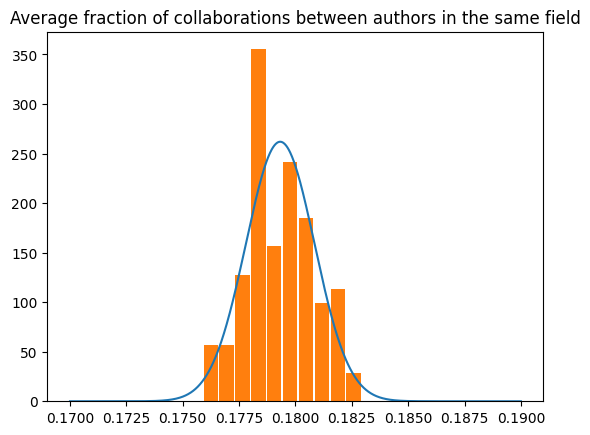

In [150]:
x = np.linspace(0.17, 0.19, 1000)

fractions = np.array(graph_fractions)
plt.plot(x, norm.pdf(x, loc=np.mean(fractions), scale=np.std(fractions)))
plt.hist(fractions, bins=10, rwidth=0.9, density=True)
plt.title("Average fraction of collaborations between authors in the same field")
plt.show()

**Questions 2 and 3**  
*Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.  
Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?*  
**Answer**  
The values we obtain when shuffling the fields are all between 0.17 and 0.19. This is a very narrow range but due to the size of the network, outliers become quite rare.  
The value we obtained for the actual network of 0.59 is approximately 270 standard deviations away from the mean of the random values and is thereby significantly higher than it would be by chance.
This showcases that there is a tendency for authors to collaborate with authors in the same field as one might expect.

To compute the assortativity coefficient, we use the formula 
$$
r=\cfrac{\sum_i e_{ii} - \sum_i a_ib_i}{1-\sum_ia_ib_i}=\cfrac{Tr(e)-||e^2||}{1-||e^2||}
$$

where
$e_{ij}$ is the fraction of edges that go between author authors in field i and authors in field j.  
and 
$$
a_i=\sum_je_{ij}, b_j = \sum_i e_{ij}
$$

We start with computing the nonzero elements of $e$

In [198]:
unique_fields = set()
e_dict = {}

# count the occurences of an edge (field1, field2)
for node, attributes in G0.nodes.items():
    field1 = attributes["field"]
    unique_fields.add(field1)

    for n in G0.adj[node].keys():
        field2 = G0.nodes[n]["field"]
        t = (field1, field2)
        if t in e_dict:
            e_dict[t] += 1
        else:
            e_dict[t] = 1

In [199]:
# convert the counts to fractions
denominator = G0.number_of_edges() * 2

for k, v in e_dict.items():
    e_dict[k] = v / denominator

In [200]:
# map the fields to indices in the e_matrix
field_to_int_map = {}
for i, field in enumerate(unique_fields):
    field_to_int_map[field] = i

In [201]:
# create the e_matrix
e_matrix = np.zeros((len(unique_fields), len(unique_fields)))
for k, v in e_dict.items():
    i = field_to_int_map[k[0]]
    j = field_to_int_map[k[1]]

    e_matrix[i, j] = v

In [202]:
# calculate the assortativity coefficient
assort_coef = (np.trace(e_matrix) - np.sum(e_matrix @ e_matrix)) / (1 - np.sum(e_matrix @ e_matrix))

In [204]:
print(f"Assortativity coefficient: {assort_coef}")

Assortativity coefficient: 0.7204848076170218


**Question 4**  
*Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain?*  
**Answer**  
According to the [paper](https://arxiv.org/pdf/cond-mat/0209450.pdf), the value of the coefficient is 0 when there is no assortative mixing and 1 when there is perfect assortative mixing. With a value of 0.72 we have a high degree of assortative mixture with respect to field which indicates that authors often work with authors within their own field which we have already confirmed

For the final question of part 1, we are allowed to use the built-in degree assortativity method so there won't be much code

In [205]:
degree_assort_coef = nx.degree_assortativity_coefficient(G0)

In [206]:
print(f"Degree assortativity coefficient: {degree_assort_coef}")

Degree assortativity coefficient: 0.26833223980955395


**Question 5**  
*Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.*  
**Answer**  
While the coefficient of 0.27 is positive, it is not as high as the coefficient with respect to field. This means that authors care less about working with the same amount of throughput and more about working with authors in the same field.
One possible contributing factor could be that a professor can advise a lot of students and thereby be coauthor on a lot of papers with a lot of authors that has written very few papers. 

# Part 2: Communities

> __Exercise 2: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 
>
> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement the _double edge swap_ algorithm. The _double edge swap_ algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network.
>       * __b.__ Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
>       * __c.__ If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
>       * Repeat steps __b.__ and __c.__ to achieve at least N swaps (I suggest N to be larger than the number of edges).
> 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.
> 7. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 8. Compute the average and standard deviation of the modularity for the random network.
> 9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?
> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

Modularity measures the connectivity of a network given a partitioning of the network. Modularity will be larger when the nodes of the partitionings are interconnected and have few outgoing edges to other groups of the network. That is if a lot of the degree within the subgraph of the partition is maintained relative to the original graph, the modularity increases.

In [25]:
karate_club = nx.karate_club_graph()

members = nx.get_node_attributes(karate_club, "club")

In [26]:
group = {i: (0 if club == "Mr. Hi" else 1) for i, club in members.items()}
nx.set_node_attributes(karate_club, group, "group")

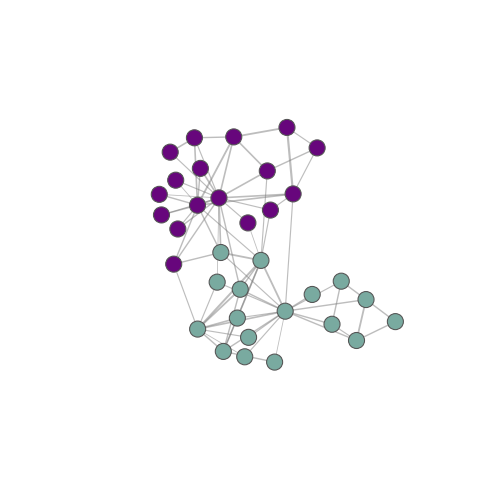

In [27]:
network, _ = visualize(karate_club)

In [28]:
clubs = list(set(members.values()))

club_partitioning = [[i for i in members.keys() if members[i] == club] for club in clubs]


In [29]:
def modularity(graph: nx.Graph, partitioning: list[int]):
    L = graph.number_of_edges()
    M = 0
    for partition in partitioning:
        community = graph.subgraph(partition)
        Lc = community.number_of_edges()
        kc = sum([node[1] for node in graph.degree(partition)]) # Get the total degree of the community members
        
        M += ((Lc / L) - (kc / (2*L)) ** 2)
        
    return M
        
modularity(karate_club, club_partitioning)

0.3582347140039447

In [30]:
import random
import copy
def double_edge_swap(original_graph: nx.Graph, nswap: int, max_tries: int = 100):
    graph = copy.deepcopy(original_graph)

    for i in range(nswap):
        for _ in range(max_tries):
            (u, v), (x, y) = random.sample(graph.edges, 2)
            if (u != v) and (v != x) and not graph.has_edge(u, y) and not graph.has_edge(x, v):
                graph.remove_edge(u, v)
                graph.remove_edge(x, y)
                graph.add_edge(u, y)
                graph.add_edge(x, v)
                break
    assert all([original == randomized for original, randomized \
                in zip(original_graph.degree, graph.degree)]), "Degrees of all nodes are not equal"
    return graph

In [31]:
modularities = []
for i in range(1000):
    randomized_graph = double_edge_swap(karate_club, 100, 1000)
    modularities.append(modularity(randomized_graph, club_partitioning))

C:\Users\rasmu\AppData\Local\Temp\ipykernel_25496\685123802.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  (u, v), (x, y) = random.sample(graph.edges, 2)


-0.08335502958579886 0.0438057693761648


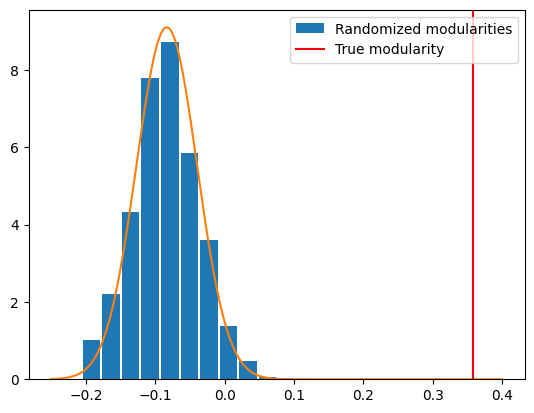

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.linspace(-0.25, 0.4, 1000)

modularities = np.array(modularities)

print(modularities.mean(), modularities.std())

plt.hist(modularities, bins=10, rwidth=0.9, density=True, label="Randomized modularities")
plt.plot(x, norm.pdf(x, loc=modularities.mean(), scale=modularities.std()))
plt.axvline(modularity(karate_club, club_partitioning), color="red", label="True modularity")
plt.legend()
plt.show()

The club partitioning seems very natural and serves as a good segmentation of the network.

In [33]:
louvain_partition = community.best_partition(karate_club)
communities = list(set(louvain_partition.values()))
louvain_partitioning = [[i for i, c in louvain_partition.items() if c == com] for com in communities]



modularity(karate_club, louvain_partitioning)

0.4151051939513478

The modularity of the Louvain partitioning of the Karate club graph reveals that, there exists a partitioning

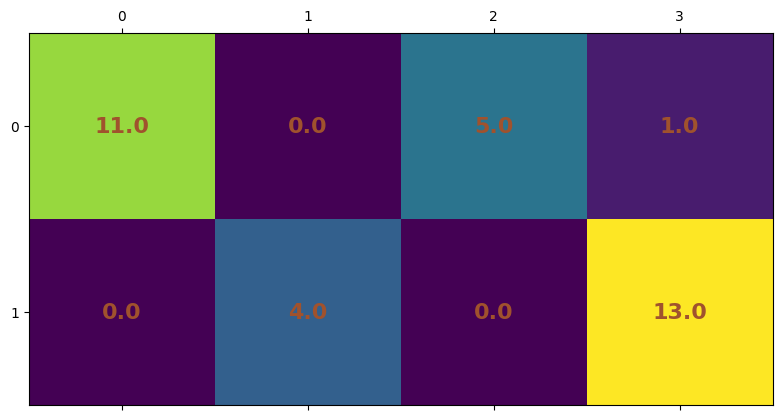

In [34]:
cm = np.zeros((2, len(communities)))

for i, club in enumerate(club_partitioning):
    for j, com in enumerate(louvain_partitioning):
        cm[i, j] = len(list(set(club).intersection(set(com))))
        
plt.matshow(cm)

for i in range(len(club_partitioning)):
    for j in range(len(louvain_partitioning)):
        plt.text(j, i, cm[i,j], fontsize=16, fontweight="semibold", ha="center", va="center", color="sienna")
plt.show()

The confusion matrix shows that it is possible to split the clubs into communities, that are still mostly self-contained within the respective clubs. There is a single member who is an exception that is from the Mr. Hi karate club, who is put into a community with the large majority from the Officer karate club.

> __Exercise 3__: Community detection on the network of Computational Social Scientists. 
>
> * Consider the network you built in [Week 4](https://github.com/lalessan/comsocsci2023/blob/main/lectures/Week4.ipynb).
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * If you are curious, you can also try the *Infomap* algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in [advanced topics 9B](http://networksciencebook.com/chapter/9#advanced-9b).
> * Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their _community_. Describe the structure you observe.
> * Make sure you save the assignment of authors to communities.


We will once again consider the largest connected component of the network, which consists of roughly 16.000 authors and 1.5 million edges

In [37]:
G0 = get_largest_component("css_graph.json")

In [38]:
author_partitions = community.best_partition(G0)
author_communities = list(set(author_partitions.values()))
author_partitioning = [[i for i, c in author_partitions.items() if c == com] for com in author_communities]

print(len(author_communities))
print(sorted([len(partition) for partition in author_partitioning]))

print(modularity(G0, author_partitioning))

52
[2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 7, 8, 8, 9, 11, 13, 21, 21, 25, 25, 39, 60, 62, 90, 92, 113, 114, 119, 129, 148, 166, 167, 183, 239, 245, 262, 270, 337, 350, 406, 414, 478, 525, 599, 652, 661, 1149, 1598, 2115, 4406]
0.6083447417624048


The algorithm finds about 50 communities, which varies a bit due to the random selections of the Louvain algorithm. Therefore the sizes of the communities also vary with the largest community consisting of 4000-5000 authors and the second largest consisting of 2000 authors.

The modularity of the author partitioning is 0.6, which indicates that the connectivity of the authors within their respective communities is strong. This can also be seen in the 

In [41]:
with open("author_partitioning.pkl", "wb") as f:
    pickle.dump(author_partitioning, f)

In [ ]:
nx.set_node_attributes(G0, author_partitions, "group")
network, config = visualize(G0)


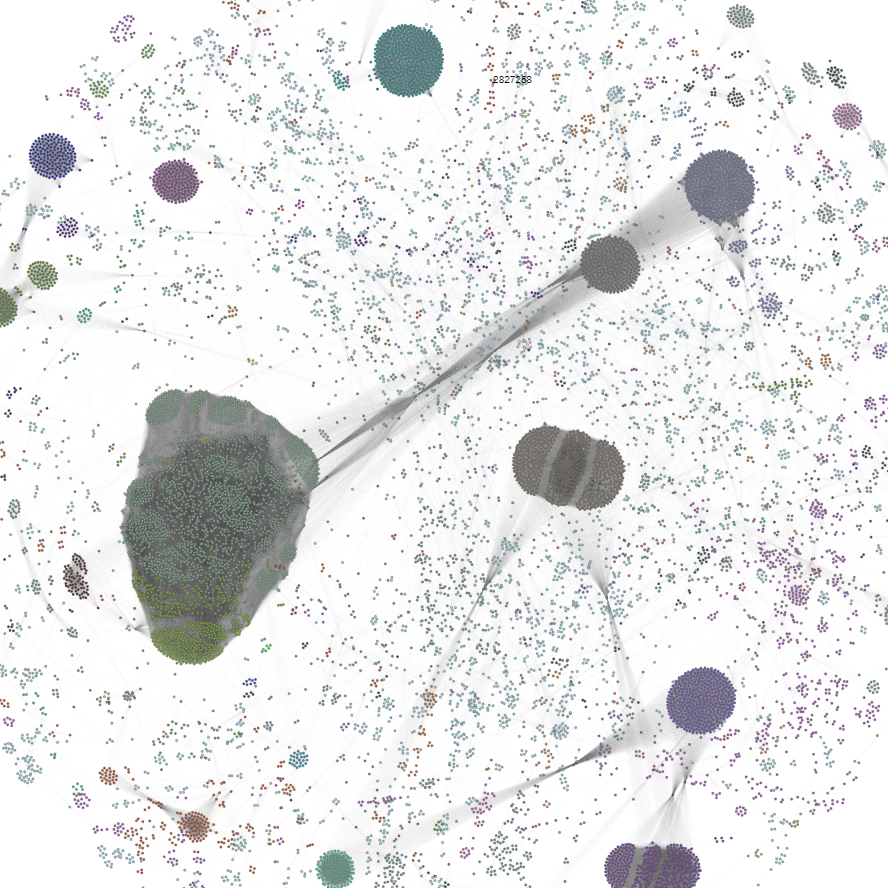

# Part 3: TF-IDF.


> __Exercise 4: TF-IDF and the Computational Social Science communities.__ The goal for this exercise is to find the words charachterizing each of the communities of Computational Social Scientists.
> What you ned for this exercise: 
>    * The assignment of each author to their network community, and the degree of each author (Week 6, Exercise 4). This can be stored in a dataframe or in two dictionaries, as you prefer.  
>    * the tokenized _abstract_ dataframe (Week 7, Exercise 2)
>
> 1. First, check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF. 
>   * What does TF stand for? 
>   * What does IDF stand for?
> 2. Now, we want to find out which words are important for each *community*, so we're going to create several ***large documents, one for each community***. Each document includes all the tokens of abstracts written by members of a given community. 
>   * Consider a community _c_
>   * Find all the abstracts of papers written by a member of community _c_.
>   * Create a long array that stores all the abstract tokens 
>   * Repeat for all the communities. 
> __Note:__ Here, to ensure your code is efficient, you shall exploit ``pandas`` builtin functions, such as [``groupby.apply``](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) or [``explode``](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html).
> 3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the __top 5 communities__ (by number of authors). 
>   * Describe similarities and differences between the communities.
>   * Why aren't the TFs not necessarily a good description of the communities?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?
> 4. We're ready to calculate TF-IDF. Do that for the __top 9 communities__ (by number of authors). Then for each community: 
>   * List the 10 top TF words 
>   * List the 10 top TF-IDF words
>   * List the top 3 authors (by degree)
>   * Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?


**Question 1.1**  
*What does TF stand for?*  
**Answer**  
TF stands for term frequency and is the number of times a term occurs in a text

**Question 1.2**  
*What does IDF stand for?*  
IDF stand for inverse document frequency which values a word based on how many documents its present in. The intuition is that a word that is present in every single document of the dataset provides little information in distinguishing documents.

In [3]:
# load the communities we found in part 2
with open("author_partitioning.pkl", "rb") as f:
    author_partitioning = pickle.load(f)

In [7]:
css_paper_df = pd.read_csv("css_papers.csv", index_col="id")

In [24]:
abstract_df = pd.read_csv("all_paper_abstracts.csv", index_col="id")

In [52]:
abstract_df = abstract_df[~abstract_df.index.duplicated(keep='first')]

In [45]:
abstract_df = abstract_df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])

In [53]:
abstract_df.head()

,abstract
id,
644ca7ada31caf3e199593bb8470ce20d2dabd3e,NaN
9be790c557637b052dc6fd12987882367762752a,Few studies have reported comparisons of out-o...
05e33b6aca9192f2f3264b58641af78db14c66fb,NaN
08372786639958bf8c2f0225fc4890727a51487e,Decreased thrombolysis in myocardial infarctio...
087b373f7a41d7000b05a54fcda0e8caed5b3f83,NaN


In [8]:
css_paper_df.head()

,title,year,doi,citations,fields,authors
id,,,,,,
2df72f572ab17cd8ea3c4b40bb9e6a8cd965345a,Redefine statistical significance,2017.0,10.1038/s41562-017-0189-z,0,['Economics'],"['34802004', '39201543', '2205017432', '286252..."
280892c93922b9b6695bbbeb859ff3886dc329a0,"Knowing Me, Knowing You: An Experiment on Mutu...",2021.0,10.2139/ssrn.3915018,0,['Economics'],"['120548063', '1778928', '87677330', '21256783..."
e6621672a033ef4e5dbc05f361c6789eabfb0eba,Simulation Models of Ethnocentrism and Diversi...,2020.0,10.1177/0894439318824316,2,['Sociology'],"['1703124', '1778928', '1404875378']"
59f44617ecdc54f23a567427b4536230aba33760,Intragenerational Cultural Evolution and Ethno...,2018.0,10.1177/0022002718780481,10,['Sociology'],"['1778928', '1703124']"
d627cd65e30c837e00871477287563b2d0f5252d,Risk Misperceptions and Selection in Insurance...,2018.0,10.1111/jori.12180,7,['Economics'],"['12977664', '1778928']"


In [73]:
# create the token document for each community
communities = [set(community) for community in author_partitioning]
community_documents = [[] for i in range(len(communities))]

In [55]:
class Tokenizer:
    stopwords = nltk.corpus.stopwords.words("english")
    stemmer = nltk.stem.porter.PorterStemmer()
    pattern = re.compile("[^a-z ]+")

    def tokenize(self, text: str) -> list[str]:
        text = text.lower()
        text = self.pattern.sub("", text)
        words = text.split()
        stemmed = [self.stemmer.stem(word) for word in words if word not in self.stopwords]
        return stemmed

In [74]:
tokenizer = Tokenizer()
for i, row in css_paper_df.iterrows():
    authors = list(map(int, ast.literal_eval(row["authors"])))

    # get abstract
    paper_id = row.name
    # print(paper_id)
    # print(abstract_df.loc[paper_id])
    if paper_id in abstract_df.index:
        abstract = abstract_df.loc[paper_id, "abstract"]
        # print(abstract)

        if not (abstract is np.nan):
            # get tokens
            tokens = tokenizer.tokenize(abstract)
            # print(tokens)
            for author in authors:
                for k, community in enumerate(communities):
                    if author in community:
                        community_documents[k].extend(tokens)
            # break

In [ ]:
with open("community_document.pkl", "wb") as f:
    pickle.dump(community_documents, f)

In [77]:
np.argpartition([2, 0], 1)

array([1, 0], dtype=int64)

In [112]:
community_tuples = []
for community, document in zip(communities, community_documents):
    community_tuples.append((document, len(community)))

In [117]:
top5_documents = sorted(community_tuples, key=lambda x: x[1], reverse=True)[:5]
top5_documents = [i for (i, k) in top5_documents]

In [118]:
top5_terms = []

for i, document in enumerate(top5_documents):
    words, counts = np.unique(document, return_counts=True)
    top5_terms.append(sorted(words, reverse=True, key=lambda x: counts[np.where(words == x)])[:5])

In [119]:
top5_terms

[['social', 'use', 'model', 'data', 'network'],
 ['social', 'use', 'media', 'research', 'commun'],
 ['injuri', 'burden', 'health', 'gbd', 'mortal'],
 ['agent', 'model', 'mechan', 'use', 'show'],
 ['injuri', 'burden', 'gbd', 'mortal', 'health']]

> __Exercise 5: The Wordcloud__. It's time to visualize our results!
> * Install the [`WordCloud`](https://pypi.org/project/wordcloud/) module. 
> * Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
> * Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration). 
> * Comment on your results. What can you conclude on the different sub-communities in Computational Social Science? 
> * Look up online the top author in each community. In light of your search, do your results make sense?